In [1]:
import numpy as np
import pandas as pd
%matplotlib inline

In [2]:
data=open('CreditSampleWindow.csv') # encoding='utf8' 有中文路径加这个  engine = python
sample_window=pd.read_csv(data) # csv是一种文本文件,格式的后缀并不能决定格式,
    # gbk编码在有大量的中文时能节省内存,相比于utf_8来讲,但是一般有少量中文文本都通用utf_8
# sample_window=pd.read_csv('CreditSampleWindow.csv',encoding='utf8')

In [3]:
sample_window.columns.values
# sample_window.columns

array(['CID', 'STAGE_BEF', 'STAGE_AFT', 'START_DATE', 'CLOSE_DATE'],
      dtype=object)

In [4]:
sample_window.shape

(1813157, 5)

In [5]:
sample_window.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1813157 entries, 0 to 1813156
Data columns (total 5 columns):
CID           object
STAGE_BEF     object
STAGE_AFT     object
START_DATE    float64
CLOSE_DATE    float64
dtypes: float64(2), object(3)
memory usage: 69.2+ MB


In [7]:
sample_window.head() # 用户ID, 本阶段前的逾期阶段, 本阶段进入的逾期阶段, 进入本阶段时间, 本阶段结束时间96

,CID,STAGE_BEF,STAGE_AFT,START_DATE,CLOSE_DATE
0,CID0128273,,M0,20170701.0,20170703.0
1,CID0214787,,M0,20180201.0,20180204.0
2,CID0287932,M4,M5,20180501.0,20180531.0
3,CID0351850,,M0,20161002.0,20161005.0
4,CID0217310,,M0,20150601.0,20150602.0


In [8]:
# 查看缺失值情况
sample_window.isnull().sum()/sample_window.shape[0]# 用count()是计数 不管对错只有有值就计数
# sample_window.isnull().mean()

CID           0.000000
STAGE_BEF     0.082451
STAGE_AFT     0.082451
START_DATE    0.082451
CLOSE_DATE    0.082451
dtype: float64

In [10]:
# 去除所有的完全重复行
sample_window.drop_duplicates(inplace=True) # duplicates 副本
sample_window.shape

(1813157, 5)

In [11]:
# 去除没有逾期阶段记录的信息
sample_window.dropna(subset=['STAGE_BEF','STAGE_AFT'], inplace=True)  # 2 个都不能为空  subset=子集
sample_window.shape

(1663660, 5)

In [12]:
sample_window["START_MONTH"] = sample_window.START_DATE.apply(lambda x: int(x//100)) # 取整后用int() 转换成整数
sample_window["CLOSE_MONTH"] = sample_window.CLOSE_DATE.apply(lambda x: int(x//100))

In [13]:
sample_window["AFT_FLAG"] = sample_window.STAGE_AFT.apply(lambda x: int(x[-1]))  #用隐函数 取x object 字符串的最后一个字符

In [14]:
sample_window.head()

,CID,STAGE_BEF,STAGE_AFT,START_DATE,CLOSE_DATE,START_MONTH,CLOSE_MONTH,AFT_FLAG
0,CID0128273,,M0,20170701.0,20170703.0,201707,201707,0
1,CID0214787,,M0,20180201.0,20180204.0,201802,201802,0
2,CID0287932,M4,M5,20180501.0,20180531.0,201805,201805,5
3,CID0351850,,M0,20161002.0,20161005.0,201610,201610,0
4,CID0217310,,M0,20150601.0,20150602.0,201506,201506,0


In [15]:
sample_window.START_MONTH.value_counts(sort=False,dropna=False) # 统计value_counts 的个数 会默认排序降序

201802     84631
201803    114688
201801     88972
201804     89660
201805     98699
201506      4890
201507      7681
201504      1904
201505      3889
201510     14301
201511     14924
201508      8671
201509     10653
201512     19574
201503      1261
201702     45787
201703     63582
201701     46767
201706     54518
201707     66470
201704     48775
201705     60673
201710     76642
201711     72530
201708     60855
201709     65924
201712     92326
201602     20096
201603     24526
201601     19359
201606     23973
201607     31698
201604     21467
201605     26327
201610     37935
201611     36087
201608     31496
201609     31285
201612     40164
Name: START_MONTH, dtype: int64

In [16]:
sample_window.CLOSE_MONTH.value_counts(sort=True,dropna=False)

201803    113132
201805     96959
201712     90765
201804     87754
201801     86811
201802     82058
201710     75386
201711     71327
201707     65599
201709     65008
201703     62956
201708     60008
201705     59899
201706     53745
201704     47828
201701     45879
201702     44791
201612     39735
201610     37562
201611     35642
201607     31242
201608     30939
201609     30716
0          28364
201605     25883
201603     24377
201606     23615
201604     21096
201602     19493
201512     19321
201601     18860
201511     14733
201510     14021
201509     10437
201508      8513
201507      7541
201506      4780
201505      3807
201504      1847
201503      1231
Name: CLOSE_MONTH, dtype: int64

In [17]:
# 将 CLOSE_DATE 为空的数据填补为 201805（根据数据缺失的业务背景确定） 为0或者为空表示至今未还,排序查看最近日期(取数据的日期)决定填201805
sample_window.loc[sample_window.CLOSE_MONTH == 0,"CLOSE_MONTH"] = 201805
#生成单个订单(进件)的流水

In [16]:
sample_window.shape

(1663660, 8)

In [18]:
# 提取 ID、月份、月份对应状态作为新的数据 # 更新其中START_MONTH 的字段名,为了以下拼接的时候 字段名一致
overdue = sample_window.loc[:,["CID","START_MONTH","AFT_FLAG"]]\
.rename(columns={"START_MONTH":"CLOSE_MONTH"})\
.append(sample_window.loc[:,["CID","CLOSE_MONTH","AFT_FLAG"]],
ignore_index=True)
overdue.shape  # 记录翻倍

(3327320, 3)

In [21]:
overdue.head()

AFT_FLAG                                                          \
CLOSE_MONTH   201503 201504 201505 201506 201507 201508 201509 201510 201511   
CID                                                                            
CID0000000       NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
CID0000001       NaN    NaN    NaN    NaN    NaN    NaN    NaN    0.0    NaN   
CID0000003       NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
CID0000004       NaN    NaN    NaN    NaN    NaN    NaN    NaN    0.0    NaN   
CID0000006       NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

                    ...                                                   \
CLOSE_MONTH 201512  ... 201708 201709 201710 201711 201712 201801 201802   
CID                 ...                                                    
CID0000000     NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
CID0000001     0.0  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
CID0000003     NaN  ...    NaN    NaN    NaN    NaN    0.0    0.0    0.0   
CID0000004     0.0  ...    0.0    NaN    0.0    NaN    1.0    0.0    0.0   
CID0000006     NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

                                  
CLOSE_MONTH 201803 201804 201805  
CID                               
CID0000000     NaN    NaN    NaN  
CID0000001     NaN    NaN    NaN  
CID0000003     NaN    NaN    NaN  
CID0000004     0.0    0.0    NaN  
CID0000006     NaN    NaN    0.0  

[5 rows x 39 columns]

In [20]:
# 生成每个订单的逾期信息
overdue = overdue.sort_values(by=["CID","CLOSE_MONTH","AFT_FLAG"])\
.drop_duplicates(subset=["CID","CLOSE_MONTH"],keep="last")\
.set_index(["CID","CLOSE_MONTH"]).unstack(1)

In [20]:
overdue.sort_values(by=["CID","CLOSE_MONTH","AFT_FLAG"]).drop_duplicates(subset=["CID","CLOSE_MONTH"],keep="last")

In [21]:
overdue.sort_values(by=["CID","CLOSE_MONTH","AFT_FLAG"]).drop_duplicates(subset=["CID","CLOSE_MONTH"],keep="last")\
# .set_index(["CID","CLOSE_MONTH"])

KeyError: 'CLOSE_MONTH'

In [22]:
overdue.head()

AFT_FLAG                                                          \
CLOSE_MONTH   201503 201504 201505 201506 201507 201508 201509 201510 201511   
CID                                                                            
CID0000000       NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
CID0000001       NaN    NaN    NaN    NaN    NaN    NaN    NaN    0.0    NaN   
CID0000003       NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
CID0000004       NaN    NaN    NaN    NaN    NaN    NaN    NaN    0.0    NaN   
CID0000006       NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

                    ...                                                   \
CLOSE_MONTH 201512  ... 201708 201709 201710 201711 201712 201801 201802   
CID                 ...                                                    
CID0000000     NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
CID0000001     0.0  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
CID0000003     NaN  ...    NaN    NaN    NaN    NaN    0.0    0.0    0.0   
CID0000004     0.0  ...    0.0    NaN    0.0    NaN    1.0    0.0    0.0   
CID0000006     NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

                                  
CLOSE_MONTH 201803 201804 201805  
CID                               
CID0000000     NaN    NaN    NaN  
CID0000001     NaN    NaN    NaN  
CID0000003     NaN    NaN    NaN  
CID0000004     0.0    0.0    NaN  
CID0000006     NaN    NaN    0.0  

[5 rows x 39 columns]

In [22]:
overdue.columns = overdue.columns.droplevel() # droplevel?

In [35]:
overdue.columns[0]

201503

In [36]:
overdue[overdue.columns[0]]

CID
CID0000000   NaN
CID0000001   NaN
CID0000003   NaN
CID0000004   NaN
CID0000006   NaN
CID0000009   NaN
CID0000010   NaN
CID0000011   NaN
CID0000013   NaN
CID0000014   NaN
CID0000015   NaN
CID0000018   NaN
CID0000019   NaN
CID0000020   NaN
CID0000022   NaN
CID0000025   NaN
CID0000027   NaN
CID0000028   NaN
CID0000030   NaN
CID0000031   NaN
CID0000032   NaN
CID0000033   NaN
CID0000034   NaN
CID0000035   NaN
CID0000036   NaN
CID0000038   NaN
CID0000039   NaN
CID0000040   NaN
CID0000041   NaN
CID0000042   NaN
              ..
CID0388219   NaN
CID0388224   NaN
CID0388225   NaN
CID0388228   NaN
CID0388229   NaN
CID0388230   NaN
CID0388231   NaN
CID0388232   NaN
CID0388234   NaN
CID0388235   NaN
CID0388236   NaN
CID0388237   NaN
CID0388238   NaN
CID0388239   NaN
CID0388240   NaN
CID0388241   NaN
CID0388244   NaN
CID0388245   NaN
CID0388246   NaN
CID0388247   NaN
CID0388248   NaN
CID0388249   NaN
CID0388250   NaN
CID0388252   NaN
CID0388253   NaN
CID0388254   NaN
CID0388255   NaN
CID0388256

In [37]:
s=(overdue[overdue.columns[0]].notnull()&overdue[overdue.columns[1]].notnull())

In [38]:
s

CID
CID0000000    False
CID0000001    False
CID0000003    False
CID0000004    False
CID0000006    False
CID0000009    False
CID0000010    False
CID0000011    False
CID0000013    False
CID0000014    False
CID0000015    False
CID0000018    False
CID0000019    False
CID0000020    False
CID0000022    False
CID0000025    False
CID0000027    False
CID0000028    False
CID0000030    False
CID0000031    False
CID0000032    False
CID0000033    False
CID0000034    False
CID0000035    False
CID0000036    False
CID0000038    False
CID0000039    False
CID0000040    False
CID0000041    False
CID0000042    False
              ...  
CID0388219    False
CID0388224    False
CID0388225    False
CID0388228    False
CID0388229    False
CID0388230    False
CID0388231    False
CID0388232    False
CID0388234    False
CID0388235    False
CID0388236    False
CID0388237    False
CID0388238    False
CID0388239    False
CID0388240    False
CID0388241    False
CID0388244    False
CID0388245    False
CID0388246    Fa

In [25]:
# overdue.head()
#构建 转移矩阵，横坐标（行）表示转移前状态，纵坐标（列）表示下一个月状态（转移后） , 选取
#连续两个月的有记录的，记录逾期阶段迁移，计算 count 录入转移矩阵。

In [41]:
import collections 
counter = collections.Counter()

In [42]:
counter

Counter()

In [48]:
import collections  #  Counter 自动统计次数  传入序列 中 子元素出现的次数.
def get_mat(df):

    """
    构建 转移矩阵，索引表示转移前的逾期状态，
    列名表示转移后的逾期状态。

    """ 
    trans_mat = pd.DataFrame(data=0,columns=range(0,10),index=range(0,10))
    counter = collections.Counter()
    for i,j in zip(df.columns,df.columns[1:]):
        select = (df[i].notnull()) & (df[j].notnull())   # select  返回布尔值
        counter += collections.Counter(tuple(x) for x in df.loc[select, [i,j]].values) # 如果select 是true 则取i j 列 的值
        # 用tuple  记录一对一对的值  并用collections.Counter 计数
    
    print(counter.keys())
    for key in counter.keys():
        trans_mat.loc[key[0],key[1]] = counter[key] # 取 key第一个值为 trans_mat 的行索引 第二个为列  对应的值为 填充值
        
    trans_mat["all_count"] = trans_mat.apply(sum, axis=1)
    bad_count = []
    for j in range(10):
        bad_count.append(trans_mat.iloc[j,j+1:10].sum())
    trans_mat["bad_count"] = bad_count
    trans_mat["to_bad"] = trans_mat["bad_count"]/trans_mat["all_count"]
    return trans_mat

In [49]:
get_mat(overdue)

dict_keys([(1.0, 0.0), (0.0, 0.0), (1.0, 1.0), (0.0, 1.0), (2.0, 2.0), (2.0, 3.0), (2.0, 1.0), (1.0, 3.0), (1.0, 2.0), (3.0, 3.0), (0.0, 2.0), (3.0, 4.0), (3.0, 0.0), (4.0, 5.0), (2.0, 0.0), (5.0, 6.0), (5.0, 5.0), (4.0, 4.0), (3.0, 2.0), (6.0, 6.0), (6.0, 7.0), (3.0, 1.0), (4.0, 1.0), (7.0, 8.0), (8.0, 9.0), (4.0, 2.0), (7.0, 7.0), (2.0, 4.0), (9.0, 9.0), (8.0, 8.0), (4.0, 0.0), (3.0, 5.0), (5.0, 7.0), (6.0, 8.0), (4.0, 6.0), (1.0, 6.0), (7.0, 9.0), (9.0, 7.0), (9.0, 8.0), (9.0, 5.0), (9.0, 6.0), (9.0, 3.0), (6.0, 3.0), (9.0, 1.0), (5.0, 2.0), (1.0, 5.0), (8.0, 7.0), (9.0, 2.0), (7.0, 6.0), (7.0, 1.0), (7.0, 4.0), (8.0, 0.0), (5.0, 1.0), (8.0, 6.0), (8.0, 1.0), (1.0, 7.0), (4.0, 7.0), (0.0, 8.0), (6.0, 9.0), (0.0, 9.0), (3.0, 9.0), (1.0, 9.0), (1.0, 8.0)])


,0,1,2,3,4,5,6,7,8,9,all_count,bad_count,to_bad
0,218269,78639,3232,0,0,0,0,0,2,2,300144,81875,0.272786
1,59218,169811,20351,9020,0,16,8,8,2,6,258440,29411,0.113802
2,556,4061,3775,17287,7,0,0,0,0,0,25686,17294,0.673285
3,184,1233,586,1686,22226,446,0,0,0,2,26363,22674,0.860069
4,1,20,5,0,233,13634,2803,8,0,0,16704,16445,0.984495
5,0,2,2,0,0,211,14936,911,0,0,16062,15847,0.986614
6,0,0,0,2,0,0,179,17223,9,8,17421,17240,0.989610
7,0,8,0,0,8,0,8,1292,14262,4,15582,14266,0.915544
8,2,2,0,0,0,0,2,4,98,12527,12635,12527,0.991452
9,0,10,2,4,0,4,8,12,22,247,309,0,0.000000


In [30]:
# 读取订单的首次动用日期信息表
data=open('CreditFirstUse.csv')
first_use =pd.read_csv(data)

In [31]:
first_use.head()

,CID,FST_USE_DT
0,CID0092102,20161116
1,CID0111878,20161118
2,CID0264977,20161120
3,CID0059996,20160907
4,CID0057096,20160910


In [32]:
first_use.set_index("CID",inplace=True)

In [33]:
first_use.head()

,FST_USE_DT
CID,
CID0092102,20161116
CID0111878,20161118
CID0264977,20161120
CID0059996,20160907
CID0057096,20160910


In [34]:
first_use["FST_USE_MONTH"] = first_use.FST_USE_DT.map(lambda x:x//100) # map?

In [35]:
first_use.head()

,FST_USE_DT,FST_USE_MONTH
CID,,
CID0092102,20161116,201611
CID0111878,20161118,201611
CID0264977,20161120,201611
CID0059996,20160907,201609
CID0057096,20160910,201609


In [36]:
# 计算每笔订单第一次出现逾期的月份索引位置
def get_first_overdue(ser):
    array = np.where(ser >= 3)[0]
    if array.size > 0:
        return array[0]
    else:
        return np.nan

In [37]:
OVERDUE_INDEX = overdue.apply(get_first_overdue,axis=1)
# 用时约 1 ～ 2 分钟

In [38]:
first_use["OVERDUE_INDEX"] = OVERDUE_INDEX

In [39]:
first_use["START_INDEX"] = first_use.FST_USE_MONTH.map({k:v for v,k in enumerate(overdue.columns)})

In [40]:
first_use.loc[first_use.OVERDUE_INDEX.notnull()].head()

,FST_USE_DT,FST_USE_MONTH,OVERDUE_INDEX,START_INDEX
CID,,,,
CID0082006,20160906,201609,26.0,18.0
CID0383647,20160906,201609,30.0,18.0
CID0006192,20161022,201610,29.0,19.0
CID0155834,20161123,201611,28.0,20.0
CID0383006,20161123,201611,30.0,20.0


In [41]:
# 查看异常数据
first_use[first_use.OVERDUE_INDEX < first_use.START_INDEX]

,FST_USE_DT,FST_USE_MONTH,OVERDUE_INDEX,START_INDEX
CID,,,,


In [42]:
sample_window.loc[sample_window.CID=="CID0164451",:]

,CID,STAGE_BEF,STAGE_AFT,START_DATE,CLOSE_DATE,START_MONTH,CLOSE_MONTH,AFT_FLAG
1115857,CID0164451,M1,M2,20151201.0,20151225.0,201512,201512,2
1298974,CID0164451,,M0,20151101.0,20151104.0,201511,201511,0
1462710,CID0164451,M0,M1,20151104.0,20151201.0,201511,201512,1
1796143,CID0164451,,M0,20170101.0,20170102.0,201701,201701,0


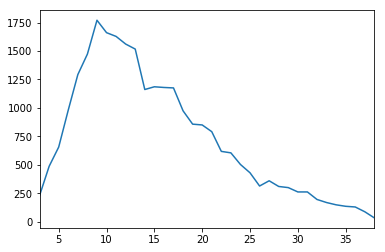

In [43]:
# 仅有一条处理时删除即可  
month_count = (first_use.OVERDUE_INDEX - first_use.START_INDEX)\
.value_counts().sort_index()[1:]
month_count.plot()  # 峰值2000 定义M2位逾期

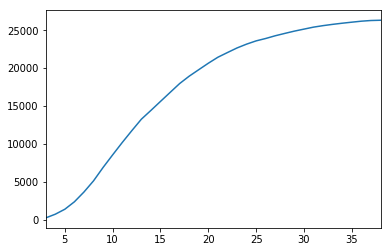

In [44]:
month_count.cumsum().plot()

In [53]:
 # 载入数据
data=open('cs-training.csv')
train_data =pd.read_csv(data)

In [54]:
path = 'cs-training.csv'
train_data = pd.read_csv(path, index_col=0, engine="python")

In [55]:
# 查看数据分布
train_data.describe().T

,count,mean,std,min,25%,50%,75%,max
SeriousDlqin2yrs,150000.0,0.066840,0.249746,0.0,0.000000,0.000000,0.000000,1.0
RevolvingUtilizationOfUnsecuredLines,150000.0,6.048438,249.755371,0.0,0.029867,0.154181,0.559046,50708.0
age,150000.0,52.295207,14.771866,0.0,41.000000,52.000000,63.000000,109.0
NumberOfTime30-59DaysPastDueNotWorse,150000.0,0.421033,4.192781,0.0,0.000000,0.000000,0.000000,98.0
DebtRatio,150000.0,353.005076,2037.818523,0.0,0.175074,0.366508,0.868254,329664.0
MonthlyIncome,120269.0,6670.221237,14384.674215,0.0,3400.000000,5400.000000,8249.000000,3008750.0
NumberOfOpenCreditLinesAndLoans,150000.0,8.452760,5.145951,0.0,5.000000,8.000000,11.000000,58.0
NumberOfTimes90DaysLate,150000.0,0.265973,4.169304,0.0,0.000000,0.000000,0.000000,98.0
NumberRealEstateLoansOrLines,150000.0,1.018240,1.129771,0.0,0.000000,1.000000,2.000000,54.0
NumberOfTime60-89DaysPastDueNotWorse,150000.0,0.240387,4.155179,0.0,0.000000,0.000000,0.000000,98.0


In [56]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150000 entries, 1 to 150000
Data columns (total 11 columns):
SeriousDlqin2yrs                        150000 non-null int64
RevolvingUtilizationOfUnsecuredLines    150000 non-null float64
age                                     150000 non-null int64
NumberOfTime30-59DaysPastDueNotWorse    150000 non-null int64
DebtRatio                               150000 non-null float64
MonthlyIncome                           120269 non-null float64
NumberOfOpenCreditLinesAndLoans         150000 non-null int64
NumberOfTimes90DaysLate                 150000 non-null int64
NumberRealEstateLoansOrLines            150000 non-null int64
NumberOfTime60-89DaysPastDueNotWorse    150000 non-null int64
NumberOfDependents                      146076 non-null float64
dtypes: float64(4), int64(7)
memory usage: 13.7 MB


In [58]:
train_data.notnull().mean()

SeriousDlqin2yrs                        1.000000
RevolvingUtilizationOfUnsecuredLines    1.000000
age                                     1.000000
NumberOfTime30-59DaysPastDueNotWorse    1.000000
DebtRatio                               1.000000
MonthlyIncome                           0.801793
NumberOfOpenCreditLinesAndLoans         1.000000
NumberOfTimes90DaysLate                 1.000000
NumberRealEstateLoansOrLines            1.000000
NumberOfTime60-89DaysPastDueNotWorse    1.000000
NumberOfDependents                      0.973840
dtype: float64

In [63]:
train_data.drop_duplicates(inplace=True)

In [64]:
train_data.shape

(149391, 11)

In [65]:
import missingno as msno

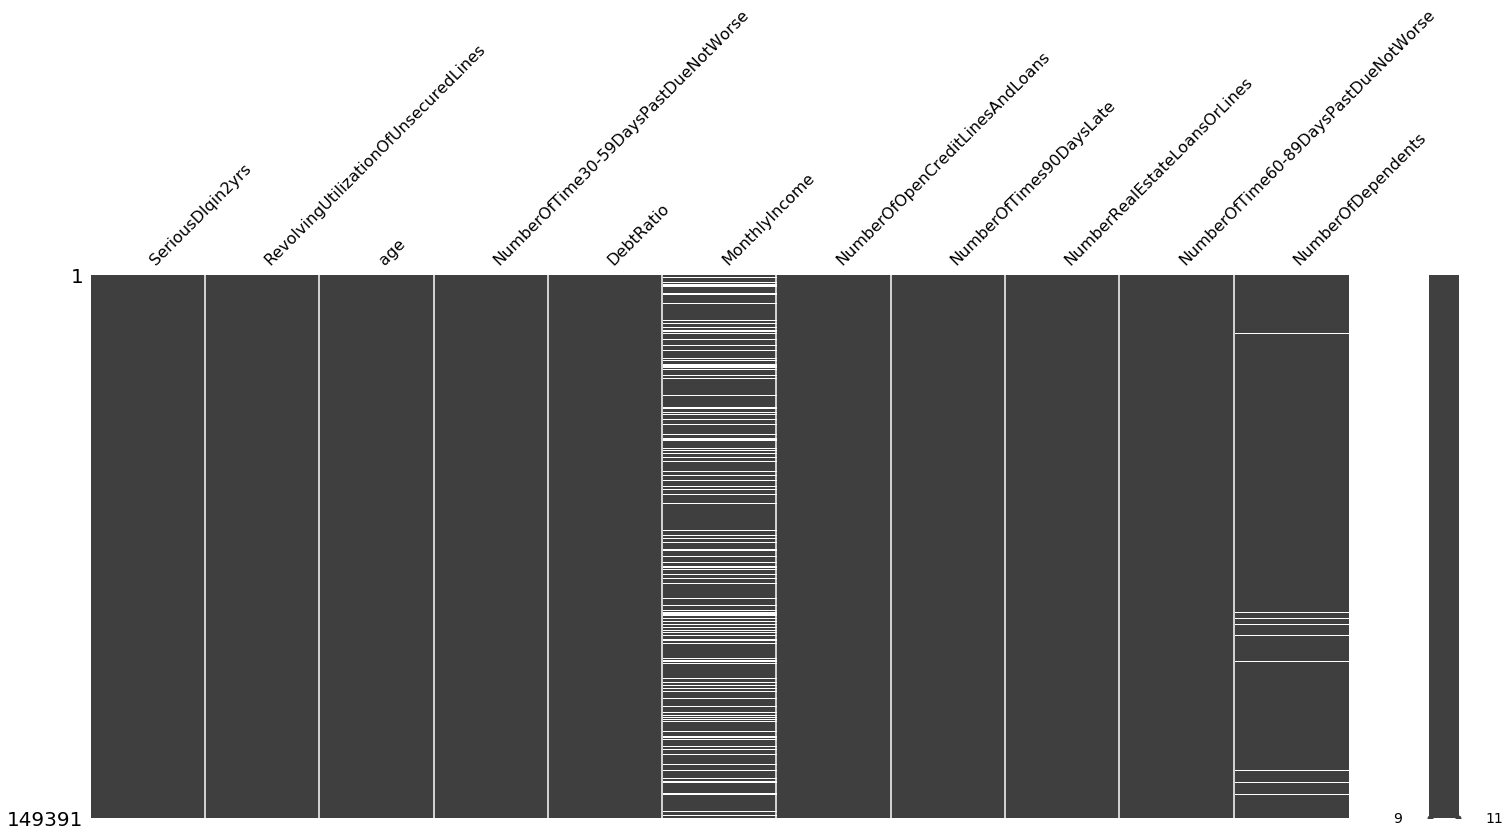

In [66]:
msno.matrix(train_data)

In [67]:
 median = train_data.MonthlyIncome.median()

In [68]:
train_data.MonthlyIncome.fillna(value=median, inplace=True)  # 在做缺失值填补,在训练集上的操作  原封不动的 需要的test上操作  比如填补的具体哪个值
#NumberOfDependents 变量缺失值比较少，可以考虑直接删除。

In [69]:
train_data.dropna(inplace=True)

In [70]:
train_data.isnull().mean()

SeriousDlqin2yrs                        0.0
RevolvingUtilizationOfUnsecuredLines    0.0
age                                     0.0
NumberOfTime30-59DaysPastDueNotWorse    0.0
DebtRatio                               0.0
MonthlyIncome                           0.0
NumberOfOpenCreditLinesAndLoans         0.0
NumberOfTimes90DaysLate                 0.0
NumberRealEstateLoansOrLines            0.0
NumberOfTime60-89DaysPastDueNotWorse    0.0
NumberOfDependents                      0.0
dtype: float64

## 3.2 异常值处理

异常值一般是从统计上看起来异常，但是很多时候并不代表这条数据是错误的，可能只是这条观测
和普遍情况不同而已，处理时需要谨慎。这里举一例 age 字段中包含有为 0 的值，通常认为该值为异常
值，查看数据可以发现仅有一条数据年龄为 0，因此可以直接删除。

In [71]:
train_data.age.value_counts().sort_index()

0         1
21      136
22      340
23      557
24      736
25      898
26     1142
27     1275
28     1516
29     1657
30     1893
31     2012
32     2017
33     2219
34     2121
35     2211
36     2340
37     2480
38     2595
39     2961
40     3052
41     3092
42     3052
43     3182
44     3273
45     3463
46     3656
47     3671
48     3734
49     3779
       ... 
74     1371
75     1164
76     1112
77     1026
78      985
79      908
80      819
81      704
82      592
83      456
84      435
85      431
86      364
87      306
88      263
89      241
90      163
91      122
92       81
93       70
94       35
95       37
96       14
97       12
98        5
99        4
101       3
102       3
103       3
107       1
Name: age, Length: 84, dtype: int64

In [72]:
train_data = train_data.loc[train_data.age>0]

还可以通过简单的可视化来查看异常值

In [73]:
import matplotlib.pyplot as plt

In [74]:
columns = ["NumberOfTime30-59DaysPastDueNotWorse",
"NumberOfTime60-89DaysPastDueNotWorse",
"NumberOfTimes90DaysLate"]

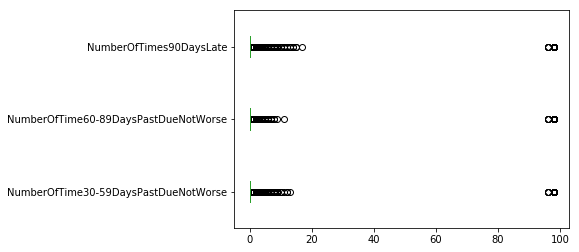

In [75]:
train_data[columns].plot.box(vert=False)

In [76]:
for col in columns:
    train_data = train_data.loc[train_data[col] < 90]

In [77]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 145354 entries, 1 to 150000
Data columns (total 11 columns):
SeriousDlqin2yrs                        145354 non-null int64
RevolvingUtilizationOfUnsecuredLines    145354 non-null float64
age                                     145354 non-null int64
NumberOfTime30-59DaysPastDueNotWorse    145354 non-null int64
DebtRatio                               145354 non-null float64
MonthlyIncome                           145354 non-null float64
NumberOfOpenCreditLinesAndLoans         145354 non-null int64
NumberOfTimes90DaysLate                 145354 non-null int64
NumberRealEstateLoansOrLines            145354 non-null int64
NumberOfTime60-89DaysPastDueNotWorse    145354 non-null int64
NumberOfDependents                      145354 non-null float64
dtypes: float64(4), int64(7)
memory usage: 13.3 MB


## 3.3 数据集划分

数据集的划分原则上应当在缺失值和异常值处理之前就进行，也就是说从数据预处理阶段开始， 验
证集和测试集就不应参与到模型构建的各个阶段中来，而应仅使用训练集得到的信息，这样才能有效严
谨的保证模型验证和评估不会出现潜在的过拟合问题。此外，因为评分卡与其他机器学习略有区别，评
分卡的数据是带有时间因素的而并非单纯的截面数据，因此，在划分数据集的时候，应当使用更早时间
段的数据作为训练集，稍晚和最晚的时间段的数据分别作为验证集和测试集。同时，合理划分数据集后
应当保证训练集、验证集和测试集和数据分布应当相同。（使用指标请参考模型监控部分的 PSI 指标）

In [78]:
from sklearn.model_selection import train_test_split

此处简单化处理数据仅随机划分为训练集和验证集，训练集用于提供模型训练，验证集用于提供模
型调整。（请注意，原则上需要考虑时间窗口且要有测试集来做最后的模型评估。）

In [79]:
Y = train_data['SeriousDlqin2yrs']
X = train_data.iloc[:, 1:]
X_train, X_vali, Y_train, Y_vali = train_test_split(X, Y, test_size=0.3)

In [80]:
model_data = pd.concat([Y_train, X_train], axis=1)
vali_data = pd.concat([Y_vali, X_vali], axis=1)

## 3.4 探索性数据分析

探索性数据分析是一系列的方法，它的目的就是让你最大化对数据的直觉，了解数据中包含哪些信
息并且不包含哪些信息。为了直观展示通常我们会利用一些基本的图形绘制：直方图、散点图和箱线图
等。少数情况下会使用一些高级图形展示变量之间的关系等等。

In [81]:
# 查看数据分布
model_data.describe([.01,.1,.25,.5,.75,.9,.99]).T

,count,mean,std,min,1%,10%,25%,50%,75%,90%,99%,max
SeriousDlqin2yrs,101747.0,0.066823,0.249716,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000,1.0
RevolvingUtilizationOfUnsecuredLines,101747.0,5.142269,186.123208,0.0,0.0,0.003371,0.030906,0.156892,0.556367,0.97266,1.092094,20514.0
age,101747.0,52.104278,14.569305,21.0,24.0,33.000000,41.000000,52.000000,62.000000,72.00000,86.000000,107.0
NumberOfTime30-59DaysPastDueNotWorse,101747.0,0.248037,0.703821,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.00000,3.000000,13.0
DebtRatio,101747.0,338.456119,2156.121012,0.0,0.0,0.035269,0.175076,0.359420,0.767441,1151.80000,4939.540000,329664.0
MonthlyIncome,101747.0,6472.366517,14544.035149,0.0,0.0,2300.000000,3815.000000,5400.000000,7500.000000,10833.00000,23568.640000,3008750.0
NumberOfOpenCreditLinesAndLoans,101747.0,8.555545,5.135325,0.0,1.0,3.000000,5.000000,8.000000,11.000000,15.00000,25.000000,58.0
NumberOfTimes90DaysLate,101747.0,0.092651,0.494774,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,2.000000,17.0
NumberRealEstateLoansOrLines,101747.0,1.034959,1.136648,0.0,0.0,0.000000,0.000000,1.000000,2.000000,2.00000,5.000000,54.0
NumberOfTime60-89DaysPastDueNotWorse,101747.0,0.065663,0.328151,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,2.000000,8.0


In [83]:
model_data.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
51752,0,0.080809,66,0,2210.000000,5400.0,9,0,1,0,0.0
62162,0,0.107600,69,0,2436.000000,5400.0,8,0,1,0,0.0
116060,0,0.048137,77,2,0.046558,3500.0,12,0,0,0,2.0
26330,1,0.549686,43,1,0.026460,9334.0,6,0,0,1,0.0
100120,0,0.236026,53,1,0.439621,3800.0,5,1,1,1,0.0


In [84]:
model_data["SeriousDlqin2yrs"].value_counts()  #  1:5 以下 可以不做样本均衡

0    94948
1     6799
Name: SeriousDlqin2yrs, dtype: int64

In [85]:
# 考虑是否需要进行样本平衡

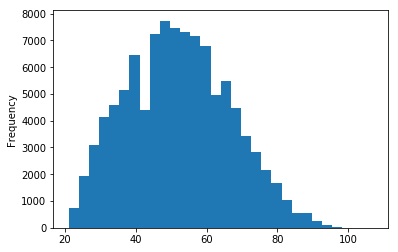

In [86]:
model_data["age"].plot.hist(bins=30)

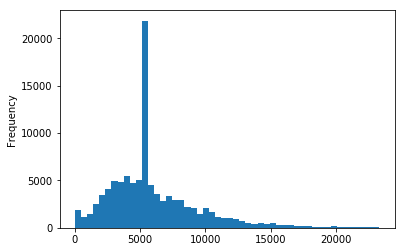

In [87]:
# 可以看出收入有少部分人非常高，使用小于 99% 的分位数的数据查看收入分布
income = model_data["MonthlyIncome"]
income.loc[income < 23334].plot.hist(bins=50)

In [88]:
model_data.corr().to_excel('CorrData.xlsx')

In [89]:
pd.__version__    

# import auto_bin
# from auto_bin import AutoBins

# import importlib
# importlib.reload(auto_bin)  重新导入一个库的方式 

# import auto_bin
# from auto_bin import AutoBins  

'0.24.0'

In [90]:
from auto_bin import AutoBins

In [91]:
bins_data = AutoBins(model_data, "SeriousDlqin2yrs")

In [92]:
model_data.columns

Index(['SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents'],
      dtype='object')

In [93]:
# 分析过程中手动完成分箱个数的添加
bins_num = {
"RevolvingUtilizationOfUnsecuredLines":5,
"age":5,
"NumberOfTime30-59DaysPastDueNotWorse":3,
"DebtRatio":5,
"MonthlyIncome":6,
"NumberOfOpenCreditLinesAndLoans":4,
"NumberOfTimes90DaysLate":2,
"NumberRealEstateLoansOrLines":4,
"NumberOfTime60-89DaysPastDueNotWorse":2,
"NumberOfDependents":4,
}

In [94]:
pd.read_csv

<function pandas.io.parsers._make_parser_function.<locals>.parser_f(filepath_or_buffer, sep=',', delimiter=None, header='infer', names=None, index_col=None, usecols=None, squeeze=False, prefix=None, mangle_dupe_cols=True, dtype=None, engine=None, converters=None, true_values=None, false_values=None, skipinitialspace=False, skiprows=None, skipfooter=0, nrows=None, na_values=None, keep_default_na=True, na_filter=True, verbose=False, skip_blank_lines=True, parse_dates=False, infer_datetime_format=False, keep_date_col=False, date_parser=None, dayfirst=False, iterator=False, chunksize=None, compression='infer', thousands=None, decimal=b'.', lineterminator=None, quotechar='"', quoting=0, doublequote=True, escapechar=None, comment=None, encoding=None, dialect=None, tupleize_cols=None, error_bad_lines=True, warn_bad_lines=True, delim_whitespace=False, low_memory=True, memory_map=False, float_precision=None)>

In [107]:
# 通过下面的函数来完成分箱个数的判断 箱体是前开后闭
num_bins, woe_df, iv = bins_data.auto_bins("age",n=5)

对 age 列进行分箱: 
分组个数: 20 	iv值: 0.2495658989138711
分组个数: 19 	iv值: 0.24954540464831224
分组个数: 18 	iv值: 0.24953664019430288
分组个数: 17 	iv值: 0.24951122617761973
分组个数: 16 	iv值: 0.24948692616062113
分组个数: 15 	iv值: 0.2494522333712063
分组个数: 14 	iv值: 0.2493061444022752
分组个数: 13 	iv值: 0.2491611224447199
分组个数: 12 	iv值: 0.24888761387925115
分组个数: 11 	iv值: 0.24829762774323672
分组个数: 10 	iv值: 0.24801164341024645
分组个数: 09 	iv值: 0.24755121954963488
分组个数: 08 	iv值: 0.24709571940156885
分组个数: 07 	iv值: 0.24640502149089621
分组个数: 06 	iv值: 0.24479187702419708
分组个数: 05 	iv值: 0.24138152665251628

最后分箱情况: 
分组个数: 05 	iv值: 0.24138152665251628

分组woe情况：
    min   max  count_0  count_1  total  percentage  bad_rate       woe
0  -inf  36.0    14325     1783  16108    0.158314  0.110690 -0.552845
1  36.0  46.0    19748     1891  21639    0.212675  0.087389 -0.290607
2  46.0  56.0    23186     1771  24957    0.245285  0.070962 -0.064550
3  56.0  62.0    13301      659  13960    0.137203  0.047206  0.368317
4  62.0   inf    243

In [96]:
num_bins, woe_df, iv = bins_data.auto_bins("RevolvingUtilizationOfUnsecuredLines",n=5)

对 RevolvingUtilizationOfUnsecuredLines 列进行分箱: 
分组个数: 19 	iv值: 1.1618064278981959
分组个数: 18 	iv值: 1.1617246559121777
分组个数: 17 	iv值: 1.1616781862227676
分组个数: 16 	iv值: 1.1614880492758004
分组个数: 15 	iv值: 1.1610604921157173
分组个数: 14 	iv值: 1.1605727901514318
分组个数: 13 	iv值: 1.1598943937263237
分组个数: 12 	iv值: 1.1587671231462426
分组个数: 11 	iv值: 1.1578429060096682
分组个数: 10 	iv值: 1.1559999148812194
分组个数: 09 	iv值: 1.1502508870474404
分组个数: 08 	iv值: 1.1458110462397086
分组个数: 07 	iv值: 1.1418122626758342
分组个数: 06 	iv值: 1.118018626209705
分组个数: 05 	iv值: 1.0973321818363109

最后分箱情况: 
分组个数: 05 	iv值: 1.0973321818363109

分组woe情况：
        min       max  count_0  count_1  total  percentage  bad_rate       woe
0      -inf  0.116210    44946      840  45786    0.449999  0.018346  1.343261
1  0.116210  0.351957    19617      732  20349    0.199996  0.035972  0.651817
2  0.351957  0.843863    18462     1888  20350    0.200006  0.092776 -0.356357
3  0.843863  1.000000    10500     2527  13027    0.128033  0.193982 -1.21

In [97]:
num_bins, woe_df, iv = bins_data.auto_bins("NumberOfTime30-59DaysPastDueNotWorse",n=5)

对 NumberOfTime30-59DaysPastDueNotWorse 列进行分箱: 

最后分箱情况: 
分组个数: 04 	iv值: 0.7356009931454139

分组woe情况：
   min  max  count_0  count_1  total  percentage  bad_rate       woe
0 -inf  0.0    82081     3448  85529    0.840605  0.040314  0.533358
1  0.0  1.0     9301     1663  10964    0.107757  0.151678 -0.915055
2  1.0  2.0     2299      840   3139    0.030851  0.267601 -1.629726
3  2.0  inf     1267      848   2115    0.020787  0.400946 -2.235027


In [98]:
num_bins, woe_df, iv = bins_data.auto_bins("DebtRatio",n=5)

对 DebtRatio 列进行分箱: 
分组个数: 20 	iv值: 0.08600256252782218
分组个数: 19 	iv值: 0.08599740794609398
分组个数: 18 	iv值: 0.08598325741955168
分组个数: 17 	iv值: 0.08593130687358547
分组个数: 16 	iv值: 0.08591395744672836
分组个数: 15 	iv值: 0.08578309421901154
分组个数: 14 	iv值: 0.08548972337446448
分组个数: 13 	iv值: 0.08515022141734388
分组个数: 12 	iv值: 0.08473254876690123
分组个数: 11 	iv值: 0.0840849218115729
分组个数: 10 	iv值: 0.08277016300288034
分组个数: 09 	iv值: 0.08054653515949727
分组个数: 08 	iv值: 0.07806226963271076
分组个数: 07 	iv值: 0.07507302779465544
分组个数: 06 	iv值: 0.06968418512457314
分组个数: 05 	iv值: 0.059535152726366204

最后分箱情况: 
分组个数: 05 	iv值: 0.059535152726366204

分组woe情况：
           min          max  count_0  count_1  total  percentage  bad_rate  \
0         -inf     0.000000     1984      169   2153    0.021160  0.078495   
1     0.000000     0.516449    60182     3800  63982    0.628834  0.059392   
2     0.516449     1.357499    13712     1550  15262    0.150000  0.101559   
3     1.357499  1151.800000     9397      778  10175

In [99]:
num_bins, woe_df, iv = bins_data.auto_bins("MonthlyIncome",n=5)

对 MonthlyIncome 列进行分箱: 
分组个数: 18 	iv值: 0.07607745289113654
分组个数: 17 	iv值: 0.07607126743875513
分组个数: 16 	iv值: 0.07606197619501504
分组个数: 15 	iv值: 0.07605433858028383
分组个数: 14 	iv值: 0.07604415395002372
分组个数: 13 	iv值: 0.07603424611158964
分组个数: 12 	iv值: 0.07590272433802349
分组个数: 11 	iv值: 0.07577853750917089
分组个数: 10 	iv值: 0.07556830380470776
分组个数: 09 	iv值: 0.07524229112539073
分组个数: 08 	iv值: 0.0742923515573741
分组个数: 07 	iv值: 0.07367040735310917
分组个数: 06 	iv值: 0.07124268249851473
分组个数: 05 	iv值: 0.0689569228795487

最后分箱情况: 
分组个数: 05 	iv值: 0.0689569228795487

分组woe情况：
      min     max  count_0  count_1  total  percentage  bad_rate       woe
0    -inf  1500.0     4888      370   5258    0.051677  0.070369 -0.055518
1  1500.0  3333.0    13742     1476  15218    0.149567  0.096990 -0.405433
2  3333.0  4793.0    13886     1251  15137    0.148771  0.082645 -0.229616
3  4793.0  9500.0    47937     3030  50967    0.500919  0.059450  0.124771
4  9500.0     inf    14495      672  15167    0.149066  0.0

In [100]:
num_bins, woe_df, iv = bins_data.auto_bins("NumberOfOpenCreditLinesAndLoans",n=2)

对 NumberOfOpenCreditLinesAndLoans 列进行分箱: 
分组个数: 15 	iv值: 0.09993782742293887
分组个数: 14 	iv值: 0.09992087988425419
分组个数: 13 	iv值: 0.09985943561228049
分组个数: 12 	iv值: 0.09982934498087187
分组个数: 11 	iv值: 0.0997673569084605
分组个数: 10 	iv值: 0.09964637860451939
分组个数: 09 	iv值: 0.09943754861212224
分组个数: 08 	iv值: 0.09913459476201127
分组个数: 07 	iv值: 0.09867579566385924
分组个数: 06 	iv值: 0.09787630432993073
分组个数: 05 	iv值: 0.09580696824694589
分组个数: 04 	iv值: 0.08830067429373098
分组个数: 03 	iv值: 0.08338876624802605
分组个数: 02 	iv值: 0.0698518037278718

最后分箱情况: 
分组个数: 02 	iv值: 0.0698518037278718

分组woe情况：
   min  max  count_0  count_1  total  percentage  bad_rate       woe
0 -inf  2.0     7049     1068   8117    0.079776  0.131576 -0.749456
1  2.0  inf    87899     5731  93630    0.920224  0.061209  0.093745


In [101]:
# "NumberOfTimes90DaysLate":2,
# "NumberRealEstateLoansOrLines":4,
# "NumberOfTime60-89DaysPastDueNotWorse":2,
# "NumberOfDependents":4,

In [102]:
num_bins, woe_df, iv = bins_data.auto_bins("NumberOfTimes90DaysLate",n=2)

对 NumberOfTimes90DaysLate 列进行分箱: 
分组个数: 02 	iv值: 0.8307643707539404

最后分箱情况: 
分组个数: 02 	iv值: 0.8307643707539404

分组woe情况：
   min  max  count_0  count_1  total  percentage  bad_rate       woe
0 -inf  0.0    91714     4470  96184    0.945325  0.046473  0.384733
1  0.0  inf     3234     2329   5563    0.054675  0.418659 -2.308273


In [103]:
num_bins, woe_df, iv = bins_data.auto_bins("NumberRealEstateLoansOrLines",n=4)

对 NumberRealEstateLoansOrLines 列进行分箱: 
分组个数: 04 	iv值: 0.06128831410292929

最后分箱情况: 
分组个数: 04 	iv值: 0.06128831410292929

分组woe情况：
   min  max  count_0  count_1  total  percentage  bad_rate       woe
0 -inf  0.0    34100     3085  37185    0.365465  0.082964 -0.233808
1  0.0  2.0    54599     3124  57723    0.567319  0.054121  0.224348
2  2.0  3.0     4003      287   4290    0.042163  0.066900 -0.001237
3  3.0  inf     2246      303   2549    0.025052  0.118870 -0.633381


In [133]:
num_bins, woe_df, iv = bins_data.auto_bins("NumberOfTime60-89DaysPastDueNotWorse",n=7)

对 NumberOfTime60-89DaysPastDueNotWorse 列进行分箱: 

最后分箱情况: 
分组个数: 02 	iv值: 0.5521906366328814

分组woe情况：
   min  max  count_0  count_1  total  percentage  bad_rate       woe
0 -inf  0.0    91710     4967  96677    0.950171  0.051377  0.279262
1  0.0  inf     3238     1832   5070    0.049829  0.361341 -2.067006


In [106]:
num_bins, woe_df, iv = bins_data.auto_bins("NumberOfDependents",n=2)

对 NumberOfDependents 列进行分箱: 
分组个数: 04 	iv值: 0.03258770685814013
分组个数: 03 	iv值: 0.030282381846108195
分组个数: 02 	iv值: 0.026423888482495675

最后分箱情况: 
分组个数: 02 	iv值: 0.026423888482495675

分组woe情况：
   min  max  count_0  count_1  total  percentage  bad_rate       woe
0 -inf  0.0    56895     3526  60421    0.593836  0.058357  0.144490
1  0.0  inf    38053     3273  41326    0.406164  0.079200 -0.183281


In [ ]:
# %load auto_bin.py
# utf8
# Hsiaofei Tsien

import numpy as np
import pandas as pd
import scipy


class AutoBins:

    def __init__(self, frame, y):
        self._frame = frame.copy()
        self._y = y

    def _column_qcut(self, column):

        # 进行初始化分箱，先分成 20 个箱体
        _, bins = pd.qcut(self._frame[column], q=20, retbins=True, duplicates="drop")

        # 排除因为开闭区间导致的临界值取值问题   不做的话 第一个分箱数据太多 有些值取不到
        bins = list(bins)
        bins.insert(0, -float("inf")) # 负无穷大
        bins.append(float("inf")) # 正无穷大

        # 按照添加了最大最小值后的箱体重新分箱
        self._frame[column+"_qcut"] = pd.cut(self._frame[column], bins=bins)

        init_counts = list(self._frame[column+"_qcut"].value_counts(sort=False))
        # 查看首尾箱体是否占比超过 2%，如果没有那么将之与相邻的箱体进行合并，用于处理添加 inf 后导致的空字段的问题
        if init_counts[0] < (len(self._frame)/50):
            bins.pop(1)
        if init_counts[-1] < (len(self._frame)/50):
            bins.pop(-2)

        # 使用这个箱体的数据进行分箱并做后续的最优化合并
        self._frame[column+"_qcut"] = pd.cut(self._frame[column], bins=bins)
        # 统计每个分段 0，1的数量
        inf_init_bins = self._frame.groupby([column+"_qcut", self._y])[self._y].count().unstack()
        # num_bins值分别为每个区间的上界，下界，0的频次，1的频次
        
        num_bins = [*zip(bins, bins[1:], inf_init_bins[0], inf_init_bins[1])]  # 转换 成list
        return num_bins

    def _merge_zero_bins(self, num_bins):
        # 用于确保所有的分组均包含两种分类
        idx = 0
        while idx < len(num_bins):
            # 如果是第一个组某个分类为 0，向后合并
            if 0 in num_bins[0][2:]:
                num_bins = self._merger_bins(num_bins, idx)
                continue
            else:
                # 如果后面的组某个分类为 0 ，向前合并，合并后 num_bins 变短
                # 所以需要继续查看当前的 idx 的位置
                if 0 in num_bins[idx][2:]:
                    num_bins = self._merger_bins(num_bins, idx-1)
                    continue
                else:
                    # 如果没有出现某个分类统计为 0 ，查看下一个 idx 的位置
                    idx += 1
        return num_bins

    def _merger_bins(self, num_bins, x):
        # 合并 num_bins x 索引和 x+1 索引的分组数据
        num_bins[x: x+2] = [(
            num_bins[x][0],
            num_bins[x+1][1],
            num_bins[x][2]+num_bins[x+1][2],
            num_bins[x][3]+num_bins[x+1][3]
        )]
        return num_bins

    # 创建计算 iv 值函数
    def _get_iv(self, woe_df):
        rate = ((woe_df.count_0/woe_df.count_0.sum()) -
                (woe_df.count_1/woe_df.count_1.sum()))
        iv = np.sum(rate * woe_df.woe)
        return iv


    # 定义计算 woe 的函数
    def _get_woe(self, num_bins):
        # 通过 num_bins 数据计算 woe
        columns = ["min", "max", "count_0", "count_1"]
        df = pd.DataFrame(num_bins, columns=columns)

        df["total"] = df.count_0 + df.count_1
        df["percentage"] = df.total / df.total.sum()
        df["bad_rate"] = df.count_1 / df.total
        df["woe"] = np.log(
            (df.count_0 / df.count_0.sum()) /
            (df.count_1 / df.count_1.sum())
            )
        return df

    def _chi2_merge(self, num_bins):
        p_values = []
        # 获取 num_bins 两两之间的卡方检验的置信度（或卡方值）
        for i in range(len(num_bins)-1):
            x1 = num_bins[i][2:]
            x2 = num_bins[i+1][2:]
            # 0 返回 chi2 值，1 返回 p 值。
            pv = scipy.stats.chi2_contingency([x1, x2])[1]
            # chi2 = scipy.stats.chi2_contingency([x1, x2])[0]
            p_values.append(pv)

        # 通过 p 值进行处理。合并 p 值最大的两组
        idx = p_values.index(max(p_values))
        num_bins = self._merger_bins(num_bins, idx)
        return num_bins

    def auto_bins(self, column, n=2, show_iv=True):
        print(f"对 {column} 列进行分箱: ")
        # 初始化分箱
        num_bins = self._column_qcut(column)
        # 合并没有包含两类的分箱
        num_bins = self._merge_zero_bins(num_bins)
        # 通过 chi2_merge 不断合并最相似的相邻箱体
        while len(num_bins) > n:
            num_bins = self._chi2_merge(num_bins)
            woe_df = self._get_woe(num_bins)
            iv = self._get_iv(woe_df)
            if show_iv:
                print(f"分组个数: {len(num_bins):02d} \tiv值: {iv}")

        woe_df = self._get_woe(num_bins)
        iv = self._get_iv(woe_df)
        if show_iv:
            print("\n最后分箱情况: ")
            print(f"分组个数: {len(num_bins):02d} \tiv值: {iv}")
            print(f"\n分组woe情况：")
            print(woe_df)
        return num_bins, woe_df, iv


# if __name__ == "__main__":
    # model_data = pd.read_csv("ChiMergeData.csv", encoding="utf8")
    # bins_data = AutoBins(model_data, "SeriousDlqin2yrs")
    # bins_data.auto_bins("age", n=4)


In [115]:
bins_num

{'RevolvingUtilizationOfUnsecuredLines': 5,
 'age': 5,
 'NumberOfTime30-59DaysPastDueNotWorse': 3,
 'DebtRatio': 5,
 'MonthlyIncome': 6,
 'NumberOfOpenCreditLinesAndLoans': 4,
 'NumberOfTimes90DaysLate': 2,
 'NumberRealEstateLoansOrLines': 4,
 'NumberOfTime60-89DaysPastDueNotWorse': 2,
 'NumberOfDependents': 4}

In [108]:
info_values = {}
woe_values = {}
bins_values = {}
for key in bins_num:
    num_bins, woe_df, iv = bins_data.auto_bins(key, n=bins_num[key], show_iv=False)
    info_values[key] = iv
    woe_values[key] = woe_df
    bins_values[key] = [x[0] for x in num_bins] + [float("inf")]

对 RevolvingUtilizationOfUnsecuredLines 列进行分箱: 
对 age 列进行分箱: 
对 NumberOfTime30-59DaysPastDueNotWorse 列进行分箱: 
对 DebtRatio 列进行分箱: 
对 MonthlyIncome 列进行分箱: 
对 NumberOfOpenCreditLinesAndLoans 列进行分箱: 
对 NumberOfTimes90DaysLate 列进行分箱: 
对 NumberRealEstateLoansOrLines 列进行分箱: 
对 NumberOfTime60-89DaysPastDueNotWorse 列进行分箱: 
对 NumberOfDependents 列进行分箱: 


In [109]:
info_values

{'RevolvingUtilizationOfUnsecuredLines': 1.0973321818363109,
 'age': 0.24138152665251628,
 'NumberOfTime30-59DaysPastDueNotWorse': 0.722742266872014,
 'DebtRatio': 0.059535152726366204,
 'MonthlyIncome': 0.07124268249851473,
 'NumberOfOpenCreditLinesAndLoans': 0.08830067429373098,
 'NumberOfTimes90DaysLate': 0.8307643707539404,
 'NumberRealEstateLoansOrLines': 0.06128831410292929,
 'NumberOfTime60-89DaysPastDueNotWorse': 0.5521906366328814,
 'NumberOfDependents': 0.03258770685814013}

In [117]:
info_values.items()

dict_items([('RevolvingUtilizationOfUnsecuredLines', 1.0973321818363109), ('age', 0.24138152665251628), ('NumberOfTime30-59DaysPastDueNotWorse', 0.722742266872014), ('DebtRatio', 0.059535152726366204), ('MonthlyIncome', 0.07124268249851473), ('NumberOfOpenCreditLinesAndLoans', 0.08830067429373098), ('NumberOfTimes90DaysLate', 0.8307643707539404), ('NumberRealEstateLoansOrLines', 0.06128831410292929), ('NumberOfTime60-89DaysPastDueNotWorse', 0.5521906366328814), ('NumberOfDependents', 0.03258770685814013)])

In [123]:
def plt_iv(info_values):
    keys,values = zip(*info_values.items())  # 查看帮助文档
    nums = range(len(keys))
    plt.barh(nums,values)
    plt.yticks(nums,keys)
    for i, v in enumerate(values):  # enumerate 枚举？？？ i 是索引  v 是值
        plt.text(v, i-.2, f"{v:.2f}")
    print(keys)
    print(values)
    # enumerate() 函数用于将一个可遍历的数据对象(如列表、元组或字符串)组合为一个索引序列，同时列出数据和数据下标，一般用在 for 循环当中。

('RevolvingUtilizationOfUnsecuredLines', 'age', 'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome', 'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate', 'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfDependents')
(1.0973321818363109, 0.24138152665251628, 0.722742266872014, 0.059535152726366204, 0.07124268249851473, 0.08830067429373098, 0.8307643707539404, 0.06128831410292929, 0.5521906366328814, 0.03258770685814013)


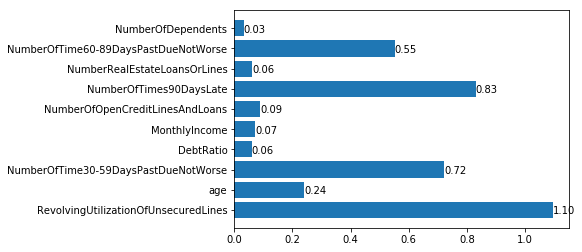

In [124]:
plt_iv(info_values)

# 5 模型构建

5.1 WOE 转换

通过生成的分箱和 WOE 数据

In [114]:
woe_values

{'RevolvingUtilizationOfUnsecuredLines':         min       max  count_0  count_1  total  percentage  bad_rate       woe
 0      -inf  0.116210    44946      840  45786    0.449999  0.018346  1.343261
 1  0.116210  0.351957    19617      732  20349    0.199996  0.035972  0.651817
 2  0.351957  0.843863    18462     1888  20350    0.200006  0.092776 -0.356357
 3  0.843863  1.000000    10500     2527  13027    0.128033  0.193982 -1.212211
 4  1.000000       inf     1423      812   2235    0.021966  0.363311 -2.075532,
 'age':     min   max  count_0  count_1  total  percentage  bad_rate       woe
 0  -inf  36.0    14325     1783  16108    0.158314  0.110690 -0.552845
 1  36.0  46.0    19748     1891  21639    0.212675  0.087389 -0.290607
 2  46.0  56.0    23186     1771  24957    0.245285  0.070962 -0.064550
 3  56.0  62.0    13301      659  13960    0.137203  0.047206  0.368317
 4  62.0   inf    24388      695  25083    0.246523  0.027708  0.921381,
 'NumberOfTime30-59DaysPastDueNotWorse'

In [125]:
# model_data.head()
model_woe = pd.DataFrame(index=model_data.index)
woe_values['age']["woe"]

0   -0.552845
1   -0.290607
2   -0.064550
3    0.368317
4    0.921381
Name: woe, dtype: float64

In [129]:
bins_values

{'RevolvingUtilizationOfUnsecuredLines': [-inf,
  0.11621027660000002,
  0.35195733850000027,
  0.8438634543000003,
  0.9999998999999999,
  inf],
 'age': [-inf, 36.0, 46.0, 56.0, 62.0, inf],
 'NumberOfTime30-59DaysPastDueNotWorse': [-inf, 0.0, 1.0, inf],
 'DebtRatio': [-inf,
  0.0,
  0.5164491367000001,
  1.357498712200001,
  1151.8000000000175,
  inf],
 'MonthlyIncome': [-inf, 1500.0, 3333.0, 4793.0, 6750.0, 9500.0, inf],
 'NumberOfOpenCreditLinesAndLoans': [-inf, 0.0, 2.0, 5.0, inf],
 'NumberOfTimes90DaysLate': [-inf, 0.0, inf],
 'NumberRealEstateLoansOrLines': [-inf, 0.0, 2.0, 3.0, inf],
 'NumberOfTime60-89DaysPastDueNotWorse': [-inf, 0.0, inf],
 'NumberOfDependents': [-inf, 0.0, 1.0, 3.0, inf]}

In [126]:
for col in bins_values:
    bins = bins_values[col]
    labels = woe_values[col]["woe"]
    model_woe[col] = pd.cut(model_data[col], bins, labels=labels).astype(float)

In [127]:
model_woe["SeriousDlqin2yrs"] = model_data["SeriousDlqin2yrs"]

In [131]:
model_woe

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,SeriousDlqin2yrs
51752,1.343261,0.921381,0.533358,0.321940,0.080945,0.137336,0.384733,0.224348,0.279262,0.144490,0
62162,1.343261,0.921381,0.533358,0.321940,0.080945,0.137336,0.384733,0.224348,0.279262,0.144490,0
116060,1.343261,0.921381,-1.888654,0.125818,-0.229616,0.137336,0.384733,-0.233808,0.279262,-0.226231,0
26330,-0.356357,-0.290607,-0.915055,0.125818,0.234480,0.137336,0.384733,-0.233808,-2.067006,0.144490,1
100120,0.651817,-0.064550,-0.915055,0.125818,-0.229616,-0.033816,-2.308273,0.224348,-2.067006,0.144490,0
95296,0.651817,-0.064550,0.533358,0.321940,-0.055518,0.137336,0.384733,0.224348,0.279262,-0.226231,0
28900,-0.356357,-0.064550,0.533358,0.125818,0.434747,0.137336,0.384733,-0.233808,0.279262,0.144490,0
21318,0.651817,-0.290607,0.533358,0.125818,-0.405433,0.137336,0.384733,-0.233808,0.279262,0.144490,0
88068,1.343261,-0.064550,0.533358,0.125818,0.080945,-0.604034,0.384733,-0.233808,0.279262,-0.075291,0
9070,1.343261,-0.064550,0.533358,0.125818,0.234480,0.137336,0.384733,0.224348,0.279262,0.144490,0


In [112]:
model_woe.to_csv('WoeData.csv',encoding="utf8", index=False)##保留中间结果

## 5.2 Logisic 模型建立

我们直接调用 statsmodels 包来实现逻辑回归：

In [132]:
import statsmodels.api as sm
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

In [118]:
%cmd
#conda remove statsmodels -y
#conda install statsmodels

UsageError: Line magic function `%cmd` not found (But cell magic `%%cmd` exists, did you mean that instead?).


In [119]:
data = pd.read_csv('WoeData.csv',encoding="utf8")

In [120]:
# 设置因变量
endog = data['SeriousDlqin2yrs']

In [121]:
X = data.drop(["SeriousDlqin2yrs",
"NumberRealEstateLoansOrLines",
"NumberOfDependents"],axis=1)

In [122]:
# 设置自变量
exog = sm.add_constant(X)

D:\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [123]:
logit = sm.Logit(endog,exog)

In [124]:
result = logit.fit()

Optimization terminated successfully.
         Current function value: 0.185382
         Iterations 8


In [125]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:       SeriousDlqin2yrs   No. Observations:               101747
Model:                          Logit   Df Residuals:                   101738
Method:                           MLE   Df Model:                            8
Date:                Sun, 31 Mar 2019   Pseudo R-squ.:                  0.2490
Time:                        11:49:16   Log-Likelihood:                -18862.
converged:                       True   LL-Null:                       -25115.
                                        LLR p-value:                     0.000
========================================================================================================
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
const                                   -2.6043      0.015   -170.881      0.000      -2.634      -2.574
RevolvingUtilizationOfUnsecuredLines    -0.6021      0.015    -40.948      0.000      -0.631      -0.573
age                                     -0.4727      0.032    -14.724      0.000      -0.536      -0.410
NumberOfTime30-59DaysPastDueNotWorse    -0.5527      0.016    -34.594      0.000      -0.584      -0.521
DebtRatio                               -0.6283      0.057    -11.006      0.000      -0.740      -0.516
MonthlyIncome                           -0.2558      0.053     -4.817      0.000      -0.360      -0.152
NumberOfOpenCreditLinesAndLoans         -0.3054      0.044     -7.006      0.000      -0.391      -0.220
NumberOfTimes90DaysLate                 -0.5458      0.014    -39.015      0.000      -0.573      -0.518
NumberOfTime60-89DaysPastDueNotWorse    -0.4192      0.017    -24.246      0.000      -0.453      -0.385
========================================================================================================
"""

## 5.3 模型检验

使用验证数据检验模型效果

In [126]:
vali_woe = pd.DataFrame(index=vali_data.index)
for col in bins_values:
    bins = bins_values[col]
    labels = woe_values[col]["woe"]
    vali_woe[col] = pd.cut(vali_data[col], bins, labels=labels).astype(np.float)

In [127]:
vali_woe["SeriousDlqin2yrs"] = vali_data["SeriousDlqin2yrs"]

In [128]:
vali_Y = vali_woe['SeriousDlqin2yrs']

In [129]:
vali_X = vali_woe.drop(["SeriousDlqin2yrs",
        "NumberRealEstateLoansOrLines",
        "NumberOfDependents"],axis=1)  

In [130]:
vali_exog = sm.add_constant(vali_X)

D:\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [143]:
vali_proba = result.predict(vali_exog)

In [156]:
import pickle # 泡菜包

In [157]:
with open('logit.model','wb') as file:
    mymodel = pickle.dump(result,file)

In [158]:
with open("logit.model", "rb") as file:
    mymodel = pickle.load(file)

In [159]:
mymodel.predict(vali_exog)

122925    0.032251
131876    0.045157
24497     0.025874
5643      0.090518
147305    0.313098
57830     0.304913
122297    0.035462
145485    0.019923
55041     0.022649
129435    0.053575
41444     0.051293
11886     0.011615
110345    0.048751
141780    0.029283
45355     0.011615
141919    0.013870
115730    0.012623
47278     0.535121
53003     0.064510
74921     0.077975
28128     0.058740
111668    0.083249
97340     0.020461
133313    0.076015
32183     0.014133
48974     0.039219
100031    0.018303
37035     0.100987
63874     0.181660
101179    0.028494
            ...   
96501     0.044077
15698     0.201452
86393     0.014969
112234    0.014133
8109      0.037580
87426     0.011615
99704     0.015786
111388    0.221946
95377     0.026445
135563    0.090216
19780     0.044077
55427     0.212714
77616     0.016044
11555     0.218258
20862     0.098132
31477     0.362988
133683    0.048212
85250     0.009488
16370     0.029204
6876      0.016091
9406      0.019880
93334     0.

In [144]:
vali_proba # 为1的概率

122925    0.032251
131876    0.045157
24497     0.025874
5643      0.090518
147305    0.313098
57830     0.304913
122297    0.035462
145485    0.019923
55041     0.022649
129435    0.053575
41444     0.051293
11886     0.011615
110345    0.048751
141780    0.029283
45355     0.011615
141919    0.013870
115730    0.012623
47278     0.535121
53003     0.064510
74921     0.077975
28128     0.058740
111668    0.083249
97340     0.020461
133313    0.076015
32183     0.014133
48974     0.039219
100031    0.018303
37035     0.100987
63874     0.181660
101179    0.028494
            ...   
96501     0.044077
15698     0.201452
86393     0.014969
112234    0.014133
8109      0.037580
87426     0.011615
99704     0.015786
111388    0.221946
95377     0.026445
135563    0.090216
19780     0.044077
55427     0.212714
77616     0.016044
11555     0.218258
20862     0.098132
31477     0.362988
133683    0.048212
85250     0.009488
16370     0.029204
6876      0.016091
9406      0.019880
93334     0.

In [134]:
# cmd 中执行 pip install scikit-plot
import scikitplot as skplt

In [147]:
vali_proba_df

,0,1
122925,0.967749,0.032251
131876,0.954843,0.045157
24497,0.974126,0.025874
5643,0.909482,0.090518
147305,0.686902,0.313098
57830,0.695087,0.304913
122297,0.964538,0.035462
145485,0.980077,0.019923
55041,0.977351,0.022649
129435,0.946425,0.053575


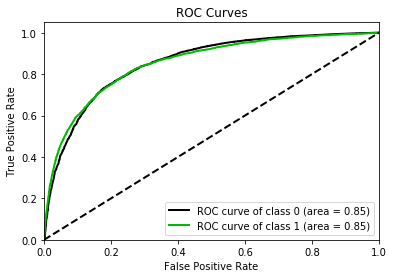

In [135]:
# 预测结果为对应 1 的概率，转换为数组用于绘图
vali_proba_df = pd.DataFrame(vali_proba,columns=[1])
vali_proba_df.insert(0,0,1-vali_proba_df)          # 添加为0的概率
skplt.metrics.plot_roc(vali_Y,
                        vali_proba_df,
                        plot_micro=False,
                        plot_macro=False)

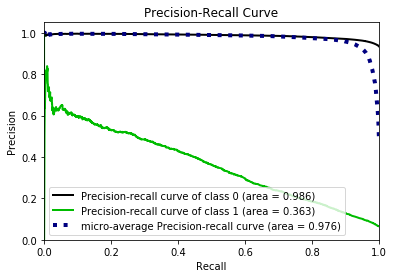

In [136]:
skplt.metrics.plot_precision_recall(vali_Y,vali_proba_df)

6 信用评分

In [137]:
B = 20/np.log(2)
A = 600 + B*np.log(1/60)
A,B

(481.8621880878296, 28.85390081777927)

In [138]:
result.params

const                                  -2.604329
RevolvingUtilizationOfUnsecuredLines   -0.602123
age                                    -0.472675
NumberOfTime30-59DaysPastDueNotWorse   -0.552750
DebtRatio                              -0.628297
MonthlyIncome                          -0.255785
NumberOfOpenCreditLinesAndLoans        -0.305407
NumberOfTimes90DaysLate                -0.545822
NumberOfTime60-89DaysPastDueNotWorse   -0.419218
dtype: float64

In [139]:
base_score = A - B*result.params["const"]
base_score

557.0072323175035

In [140]:
# 将评分卡写入文件
file = "ScoreData.csv"
with open(file,"w") as fdata:
    fdata.write(f"base_score,{base_score}\n")
for col in result.params.index[1:]:
    temp = woe_values[col]
    score = temp["woe"] * (-B*result.params[col])
    score.name = "Score"
    score.index = [("{:.2f}".format(temp.loc[x, "min"]),"{:.2f}".format(temp.loc[x, "max"])) for x in temp.index]
    score.index.name = col
    score.to_csv(file,header=True,mode="a")
#一般会对分数进行取整处理

In [165]:
# 将评分卡写入文件
file = "ScoreData.csv"
with open(file,"w") as fdata:
    fdata.write(f"base_score,{base_score}\n")
for col in result.params.index[1:]:
    tmp = woe_values[col]
    score = tmp["woe"] * (-B*result.params[col])
    score.name = "Score"
    score.index = [
        ("{:.2f}".format(tmp.loc[x,"min"]),
         "{:.2f}".format(tmp.loc[x,"max"])) for x in tmp.index]
    score.index.name = col
    score.to_csv(file,header=True,mode="a")

PermissionError: [Errno 13] Permission denied: 'ScoreData.csv'